# Week 3 Notebook - Parametric Classification and Dimensionality Reduction 
(with Sentiment Analysis)

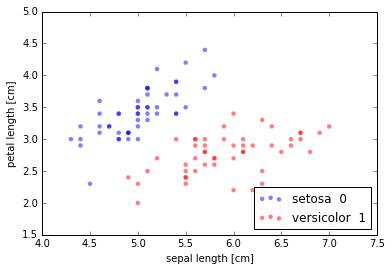

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import cross_validation
from sklearn import preprocessing
from mlclass2 import simplemetrics, plot_decision_2d_lda

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
X = df.iloc[0:100, [0,1]].values
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=5)

stdscaler = preprocessing.StandardScaler().fit(X_train)
X_scaled  = stdscaler.transform(X)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled  = stdscaler.transform(X_test)

# plot data
plt.scatter(X[:50, 0], X[:50, 1],alpha=0.5, c='b', edgecolors='none', label='setosa %2s'%(y[0]))
plt.scatter(X[50:100, 0], X[50:100, 1],alpha=0.5, c='r', edgecolors='none', label='versicolor %2s'%(y[50]))
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='lower right')
plt.show()

We need to check to see if the dimesnions are normally distributed by checking scatter plots. We can also check the Shapiro-Wilks test, when the p-value is below 0.05, it is likely our data is NOT normally distributed.

Setosa Dimension 1 Shapiro-Wilks test p-value:  0.459506511688
Setosa Dimension 2 Shapiro-Wilks test p-value:  0.204656049609
Setosa Scatter Matrix


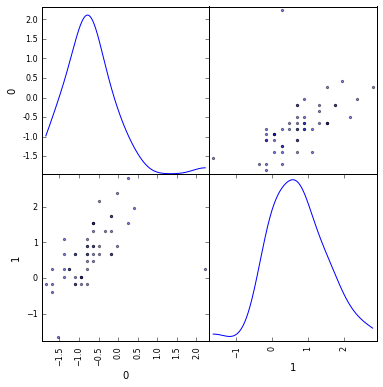

In [2]:
from scipy.stats import shapiro
from pandas.tools.plotting import scatter_matrix

print "Setosa Dimension 1 Shapiro-Wilks test p-value: ", shapiro(X_scaled[0:50,0])[1]
print "Setosa Dimension 2 Shapiro-Wilks test p-value: ", shapiro(X_scaled[0:50,1])[1]

print "Setosa Scatter Matrix"
scatter_matrix(pd.DataFrame(X_scaled).ix[:50], alpha=0.5, figsize=(6, 6), diagonal='kde');

Setosa Dimension 1 Shapiro-Wilks test p-value:  0.464748203754
Setosa Dimension 2 Shapiro-Wilks test p-value:  0.337984353304
Versicolor Scatter Matrix


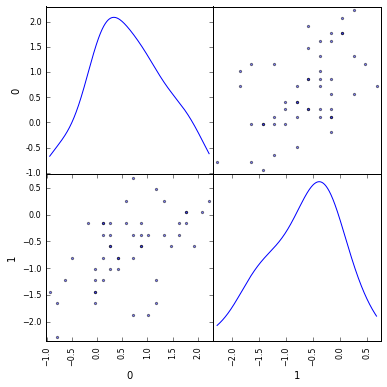

In [3]:
print "Setosa Dimension 1 Shapiro-Wilks test p-value: ", shapiro(X_scaled[50:100,0])[1]
print "Setosa Dimension 2 Shapiro-Wilks test p-value: ", shapiro(X_scaled[50:100,1])[1]

print "Versicolor Scatter Matrix"
scatter_matrix(pd.DataFrame(X_scaled).ix[50:100], alpha=0.5, figsize=(6, 6), diagonal='kde');

## Quadratic Discriminant Analysis on Iris

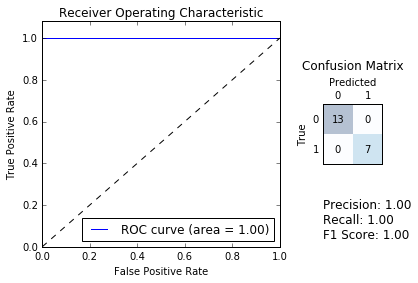

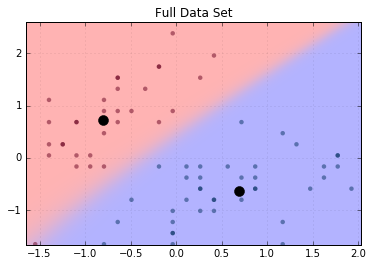

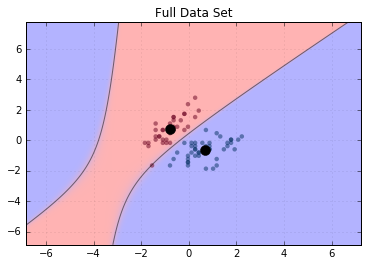

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
predicted = qda.predict(X_test_scaled)
simplemetrics(y_test,predicted)
plot_decision_2d_lda(qda,X_train_scaled,y_train,padding=-0.2,discriminant=False,title="Full Data Set",lda_on=True)
plot_decision_2d_lda(qda,X_train_scaled,y_train,padding=5,discriminant=True,title="Full Data Set",lda_on=True)

## Linear Discriminant on Iris

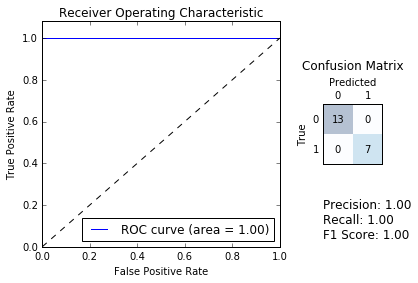

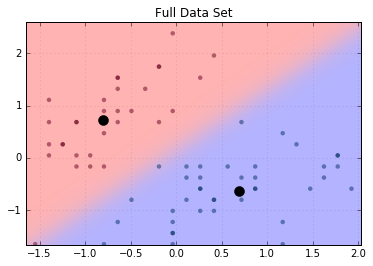

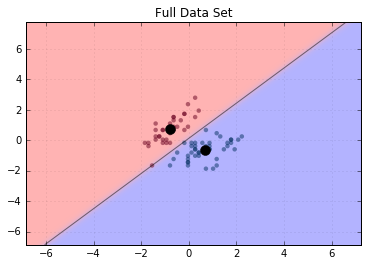

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
predicted = lda.predict(X_test_scaled)
simplemetrics(y_test,predicted)
plot_decision_2d_lda(lda,X_train_scaled,y_train,padding=-0.2,discriminant=False,title="Full Data Set",lda_on=True)
plot_decision_2d_lda(lda,X_train_scaled,y_train,padding=5,discriminant=True,title="Full Data Set",lda_on=True)

## Gaussian Naive Bayes on Iris

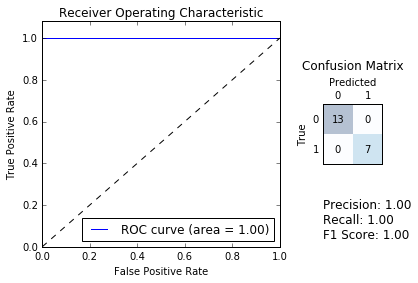

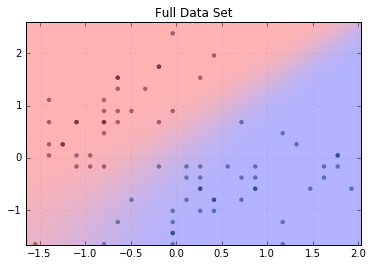

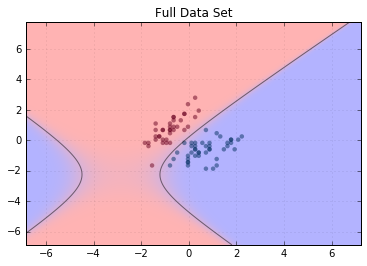

In [6]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
predicted = gnb.predict(X_test_scaled)
simplemetrics(y_test,predicted)
plot_decision_2d_lda(gnb,X_train_scaled,y_train,padding=-0.2,discriminant=False,title="Full Data Set",lda_on=False)
plot_decision_2d_lda(gnb,X_train_scaled,y_train,padding=5,discriminant=True,title="Full Data Set",lda_on=False)

# Sentiment Analysis using Naive Bayes

In this example, we will work on a big data machine learning problem: predicting the sentiment of movie reviews using Multinomial Naive Bayes. The source of these notebooks is chapter 8 in Rashka and the following blog post:
<a href="http://radimrehurek.com/data_science_python/">Practical Data Science in Python: Spam Filter</a>

In [26]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

np.random.seed(47)

reviews = pd.read_csv('./movie_data.csv')
print reviews.head()
print reviews.tail()

                                              review  sentiment
0  I went and saw this movie last night after bei...          1
1  Actor turned director Bill Paxton follows up h...          1
2  As a recreational golfer with some knowledge o...          1
3  I saw this film in a sneak preview, and it is ...          1
4  Bill Paxton has taken the true story of the 19...          1
                                                  review  sentiment
49995  Towards the end of the movie, I felt it was to...          0
49996  This is the kind of movie that my enemies cont...          0
49997  I saw 'Descent' last night at the Stockholm Fi...          0
49998  Some films that you pick up for a pound turn o...          0
49999  This is one of the dumbest films, I've ever se...          0


We need to remove HTML tags from the data.

In [8]:
reviews.ix[3][0]

"I saw this film in a sneak preview, and it is delightful. The cinematography is unusually creative, the acting is good, and the story is fabulous. If this movie does not do well, it won't be because it doesn't deserve to. Before this film, I didn't realize how charming Shia Lebouf could be. He does a marvelous, self-contained, job as the lead. There's something incredibly sweet about him, and it makes the movie even better. The other actors do a good job as well, and the film contains moments of really high suspense, more than one might expect from a movie about golf. Sports movies are a dime a dozen, but this one stands out. <br /><br />This is one I'd recommend to anyone."

In [9]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [10]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [11]:
reviews['review'] = reviews['review'].apply(preprocessor)

In [12]:
reviews.ix[3][0]

'i saw this film in a sneak preview and it is delightful the cinematography is unusually creative the acting is good and the story is fabulous if this movie does not do well it won t be because it doesn t deserve to before this film i didn t realize how charming shia lebouf could be he does a marvelous self contained job as the lead there s something incredibly sweet about him and it makes the movie even better the other actors do a good job as well and the film contains moments of really high suspense more than one might expect from a movie about golf sports movies are a dime a dozen but this one stands out this is one i d recommend to anyone '

We also need to randomize the order of reviews.

In [13]:
import numpy as np

reviews = reviews.reindex(np.random.permutation(reviews.index))

print reviews.head()
print reviews.tail()

                                                  review  sentiment
48243  i just watched this film 15 minutes ago and i ...          0
48967  dave devon sawa and his friends sam jason sege...          0
36155  this is one of the funniest movies i have ever...          1
11305  i read a viciously hidden remarks on a previou...          1
23749  this film is just another waste of time the pl...          0
                                                  review  sentiment
25267  genre dinosaur animation new york time travel ...          1
23112  although i had previously watched this one som...          0
11528  jean pierre melville s le cercle rouge follows...          1
47431  i agree with most of the columbo fans that thi...          0
38023  quite honestly the omega code is the worst mov...          0


## Basic Stats

With `pandas`, we can also view aggregate statistics easily:

In [14]:
reviews.groupby('sentiment').describe()

review
sentiment                                                          
0         count                                               25000
          unique                                              24695
          top     i see that c thomas howell has appeared in man...
          freq                                                    3
1         count                                               25000
          unique                                              24882
          top     loved today s show it was a variety and not so...
          freq                                                    5

How long are the messages?

In [15]:
reviews['length'] = reviews['review'].map(lambda text: len(text))
print reviews.head()

                                                  review  sentiment  length
48243  i just watched this film 15 minutes ago and i ...          0    1326
48967  dave devon sawa and his friends sam jason sege...          0    1036
36155  this is one of the funniest movies i have ever...          1     306
11305  i read a viciously hidden remarks on a previou...          1     748
23749  this film is just another waste of time the pl...          0     600


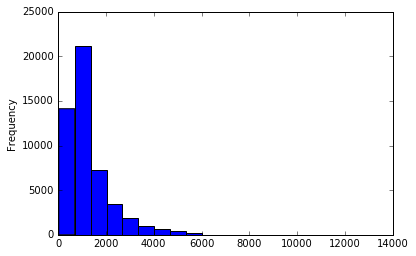

In [16]:
reviews.length.plot(bins=20, kind='hist')

In [17]:
reviews.length.describe()

count    50000.000000
mean      1253.901340
std        947.500792
min         31.000000
25%        672.000000
50%        930.000000
75%       1521.000000
max      13335.000000
Name: length, dtype: float64

What are some short reviews?

In [18]:
print list(reviews.review[reviews.length < 60].index)
print list(reviews.review[reviews.length < 60])

[17466, 23467, 19607, 21705, 21499, 38568, 41479]
['i hope this group of film makers never re unites ', 'more suspenseful more subtle much much more disturbing ', 'primary plot primary direction poor interpretation ', 'what a script what a story what a mess ', 'read the book forget the movie ', 'this movie is terrible but it has some good effects ', 'i wouldn t rent this one even on dollar rental night ']


Is there any difference in message length between positive and negative reviews?

Wall time: 228 ms


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CB37BE0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000DCDB4A8>], dtype=object)

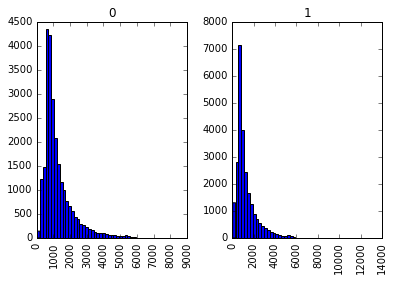

In [19]:
%%time
reviews.hist(column='length', by='sentiment', bins=50)

## Bag of Words

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, let's write a function that will split a message into its individual words:

In [20]:
def split_into_tokens(review):
    review = unicode(review, 'utf8')  # convert bytes into proper unicode
    return TextBlob(review).words

Here are some of the original texts again:
    

In [21]:
reviews.review.head()

48243    i just watched this film 15 minutes ago and i ...
48967    dave devon sawa and his friends sam jason sege...
36155    this is one of the funniest movies i have ever...
11305    i read a viciously hidden remarks on a previou...
23749    this film is just another waste of time the pl...
Name: review, dtype: object

...and here are the same messages, tokenized:

In [22]:
reviews.review.head().apply(split_into_tokens)

48243    [i, just, watched, this, film, 15, minutes, ag...
48967    [dave, devon, sawa, and, his, friends, sam, ja...
36155    [this, is, one, of, the, funniest, movies, i, ...
11305    [i, read, a, viciously, hidden, remarks, on, a...
23749    [this, film, is, just, another, waste, of, tim...
Name: review, dtype: object

NLP questions:

1. Do capital letters carry information?
2. Does distinguishing inflected form ("goes" vs. "go") carry information?
3. Do interjections, determiners carry information?

In other words, we want to better "normalize" the text.

With textblob, we'd detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [23]:
TextBlob("hello world, how is it going?").tags  # list of (word, POS) pairs

[('hello', u'JJ'),
 ('world', u'NN'),
 ('how', u'WRB'),
 ('is', u'VBZ'),
 ('it', u'PRP'),
 ('going', u'VBG')]

remove stopwords and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) with:

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsg191\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [25]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop = stop + [u'a',u'b',u'c',u'd',u'e',u'f',u'g',u'h',u'i',u'j',u'k',u'l',u'm',u'n',u'o',u'p',u'q',u'r',u's',u't',u'v',u'w',u'x',u'y',u'z']

In [26]:
def split_into_lemmas(review):
    review = unicode(review, 'utf8').lower()
    words = TextBlob(review).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words if word not in stop]

reviews.review.head().apply(split_into_lemmas)

48243    [watched, film, 15, minute, ago, still, idea, ...
48967    [dave, devon, sawa, friend, sam, jason, segel,...
36155    [one, funniest, movie, ever, seen, know, real,...
11305    [read, viciously, hidden, remark, previous, co...
23749    [film, another, waste, time, plot, ridiculous,...
Name: review, dtype: object

## Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the reviews corpus:

**Note: This will take while.**

In [27]:
%%time
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(reviews['review'])
print len(bow_transformer.vocabulary_)

93784
Wall time: 3min 21s


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [28]:
review4 = reviews['review'][17466]
print review4

i hope this group of film makers never re unites 


In [29]:
bow4 = bow_transformer.transform([review4])
print bow4

  (0, 30517)	1
  (0, 35931)	1
  (0, 39392)	1
  (0, 50725)	1
  (0, 57193)	1
  (0, 87262)	1


The bag-of-words counts for the entire reviews corpus are a large, sparse matrix:

**Note: The following will take about as long as the last long cell. **

In [30]:
%%time
reviews_bow = bow_transformer.transform(reviews['review'])
print 'sparse matrix shape:', reviews_bow.shape
print 'number of non-zeros:', reviews_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1]))

sparse matrix shape: (50000, 93784)
number of non-zeros: 4803759
sparsity: 0.10%
Wall time: 3min 30s


## Train-Test Split

Then we split the reviews and their sentiment label into training and testing sets, using the first 40,000 reviews for training and the remaining for testing.

In [31]:
reviews_bow_train = reviews_bow[:40000]
reviews_bow_test = reviews_bow[40000:]
reviews_sentiment_train = reviews['sentiment'][:40000]
reviews_sentiment_test = reviews['sentiment'][40000:]

print reviews_bow_train.shape
print reviews_bow_test.shape

(40000, 93784)
(10000, 93784)


There are a multitude of ways in which data can be proprocessed and vectorized. These two steps, also called "feature engineering", are typically the most time consuming and "un-fun" parts of building a predictive pipeline, but they are very important and require some experience. The trick is to evaluate constantly: analyze model for the errors it makes, improve data cleaning & preprocessing, brainstorm for new features, evaluate...

## Training a model, finding sentiment

With messages represented as vectors, we can finally train our sentiment classifier.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [32]:
%time review_sentiment = MultinomialNB().fit(reviews_bow_train, reviews_sentiment_train)

Wall time: 344 ms


Let's try classifying our single random message:

In [33]:
print 'predicted:', review_sentiment.predict(bow4)[0]
print 'expected:', reviews.sentiment[17466]

predicted: 0
expected: 0


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [34]:
predictions = review_sentiment.predict(reviews_bow_test)
print predictions

[0 0 1 ..., 1 1 0]


In [35]:
print 'accuracy', accuracy_score(reviews_sentiment_test, predictions)
print 'confusion matrix\n', confusion_matrix(reviews_sentiment_test, predictions)
print '(row=expected, col=predicted)'

accuracy 0.8613
confusion matrix
[[4392  606]
 [ 781 4221]]
(row=expected, col=predicted)


From this confusion matrix, we can compute precision and recall or F1:

In [36]:
print classification_report(reviews_sentiment_test, predictions)

             precision    recall  f1-score   support

          0       0.85      0.88      0.86      4998
          1       0.87      0.84      0.86      5002

avg / total       0.86      0.86      0.86     10000



We can test the system to verify it works for new reviews:

In [37]:
def predict_review(new_review): 
    new_sample = bow_transformer.transform([new_review])
    print new_review, np.around(review_sentiment.predict_proba(new_sample), decimals=5),"\n"

predict_review('Horrible. Terrible. Dreadful. Awful. Pile of garbage. Junk.')
predict_review('Fantastic. Amazing. Terrific. Classic. Best! Extraordinary. Authentic. Ideal. Vibrant. Powerful. Perfect. Imaginative. Incredible. Happy. Love. Pleasure.')
predict_review('Okay. Great.')

Horrible. Terrible. Dreadful. Awful. Pile of garbage. Junk. [[ 1.  0.]] 

Fantastic. Amazing. Terrific. Classic. Best! Extraordinary. Authentic. Ideal. Vibrant. Powerful. Perfect. Imaginative. Incredible. Happy. Love. Pleasure. [[ 0.  1.]] 

Okay. Great. [[ 0.49977  0.50023]] 



In [38]:
predict_review('Sharknado is the best movie of the century. \
 The lighting, the acting, the cinematography. All were magnificent. \
 I shall not see another movie as exceptional as this in my life time.')
predict_review('Murray, with his curious blend of pathos and aggressiveness, is terrific, and so is an acutely uptight Dreyfuss, never once copping a plea for our sympathy.')
predict_review('Somehow, Mr. Dreyfuss maintains his sound comic timing even when Frank Oz\'s antic direction calls for hand-waving hysteria.')
predict_review('To say that the movie loses the plot would not be strictly accurate, for that would imply that there was a plot to lose.')

Sharknado is the best movie of the century.  The lighting, the acting, the cinematography. All were magnificent.  I shall not see another movie as exceptional as this in my life time. [[ 0.0261  0.9739]] 

Murray, with his curious blend of pathos and aggressiveness, is terrific, and so is an acutely uptight Dreyfuss, never once copping a plea for our sympathy. [[ 0.01502  0.98498]] 

Somehow, Mr. Dreyfuss maintains his sound comic timing even when Frank Oz's antic direction calls for hand-waving hysteria. [[ 0.06524  0.93476]] 

To say that the movie loses the plot would not be strictly accurate, for that would imply that there was a plot to lose. [[ 0.94556  0.05444]] 



# Dimensionality Reduction

In [39]:
import pandas as pd

df_wine = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [40]:
df_wine['Class label'].unique()

array([1, 2, 3], dtype=int64)

In [41]:
from sklearn.cross_validation import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Sequential feature selection algorithms: Backward Selection

In [24]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

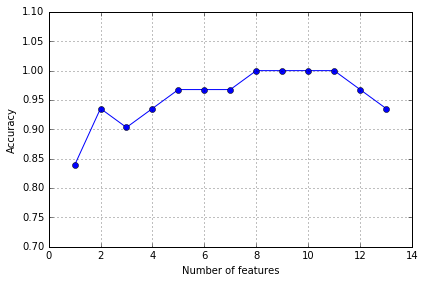

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [45]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index([u'Alcohol', u'Malic acid', u'Proanthocyanins', u'Color intensity',
       u'Proline'],
      dtype='object')


In [46]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

('Training accuracy:', 1.0)
('Test accuracy:', 0.94444444444444442)


In [47]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

('Training accuracy:', 1.0)
('Test accuracy:', 1.0)


## Principle Component Analysis

In [48]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

### Total and Explained Variance

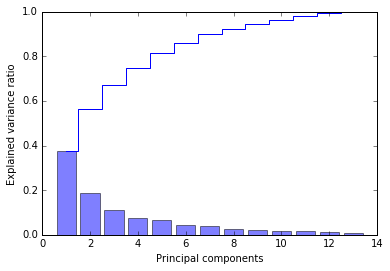

In [49]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [50]:
see

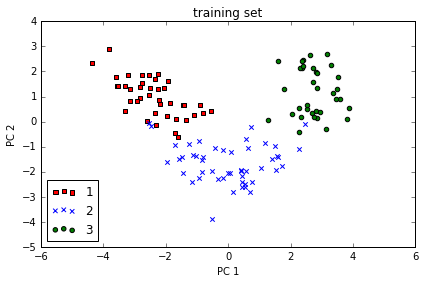

In [51]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)
plt.title('training set')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

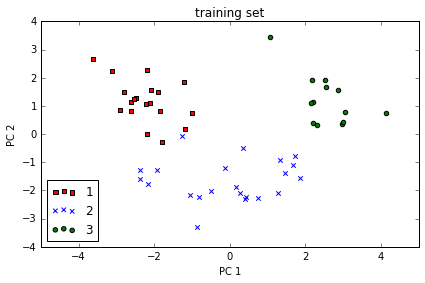

In [52]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_test), colors, markers):
    plt.scatter(X_test_pca[y_test == l, 0], 
                X_test_pca[y_test == l, 1], 
                c=c, label=l, marker=m)
plt.title('training set')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## <span style="color:red">Programming Assignment 3: Disaster Detector/Install Keras and Theano</span>

In this section of the notebook, implement using the <a href="https://www.crowdflower.com/data-for-everyone/">"Disasters on social media"</a> dataset from Crowdflower with the code presented in the Multinomial Naive Bayes section above. 

Recall that in Pandas, you subset a dataframe with square brackets after the dataframe name, this code selects the class column from the tweets dataframe:
<code>tweets['class']</code>

I start you off with code that imports the dataset.

You need to complete the following steps:

1. Remove any HTML and Emoticons from the tweets. 
2. Reindex the tweets dataframe so the rows are in random order.
3. Download stopwords from the NLTK, remove them from the tweets.
4. Create a bag-of-words for the tweets. Convert the words to lemmas and remove any stop words.
5. Split the tweets into a training and testing set, using the first 8000 tweets for training and the remaining for testing. (Do not use Scikit-learn, use the code presented above to subset the data.)
6. Apply Multinomial Naive Bayes model, show the precision and recall scores for the positive and negative classes.
7. Test your model with some text.

On testing your model, you should get results similar to this:

<code>Cat stuck in a tree. [[ 0.28597  0.71403]] 
Car accident. Major damage to property. [[ 0.22223  0.77777]] 
I ate a sandwich last night. [[ 0.97343  0.02657]] 
Somehow, Mr. Dreyfuss maintains his sound comic timing even when Frank Oz's antic direction calls for hand-waving hysteria. [[ 0.9916  0.0084]] </code>

In [5]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

tweets = pd.read_csv('socialmedia-disaster-tweets-DFE.csv')[['text','choose_one']]
tweets.columns = ['tweet','class']
tweets = tweets[(tweets['class'] == 'Relevant') | (tweets['class'] == 'Not Relevant')]
tweets = tweets.reset_index(drop=True)
tweets.tail()

,tweet,class
10855,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant
10856,Police investigating after an e-bike collided ...,Relevant
10857,The Latest: More Homes Razed by Northern Calif...,Relevant
10858,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant
10859,#CityofCalgary has activated its Municipal Eme...,Relevant


In [6]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [7]:
tweets['tweet'] = tweets['tweet'].apply(preprocessor)

In [8]:
tweets = tweets.reindex(np.random.permutation(tweets.index))

print tweets.head()
print tweets.tail()

                                                   tweet         class
10647  cutting for some celebrety and then posting th...  Not Relevant
6758   heavy rain gusty winds and vivid lightning mov...      Relevant
7748   follow up at 4700 block of sw 11th st gresham ...      Relevant
3438   dozens die as two trains derail into a river i...      Relevant
9783   billionaire mottas try getting trapped money o...  Not Relevant
                                                   tweet         class
7094   mike magner discusses a trust betrayed http t ...  Not Relevant
8815                        ik4len sirens was cancelled   Not Relevant
9940   i had trouble breathing while listening to kia...  Not Relevant
10189  2012 shell s 250 foot tall drilling rig broke ...      Relevant
1193                          eddietrunk blizzard of ozz      Relevant


In [9]:
def split_into_tokens(tweet):
    tweet = unicode(tweet, 'utf8')  # convert bytes into proper unicode
    return TextBlob(tweet).words

In [10]:
tweets.tweet.head().apply(split_into_tokens)

10647    [cutting, for, some, celebrety, and, then, pos...
6758     [heavy, rain, gusty, winds, and, vivid, lightn...
7748     [follow, up, at, 4700, block, of, sw, 11th, st...
3438     [dozens, die, as, two, trains, derail, into, a...
9783     [billionaire, mottas, try, getting, trapped, m...
Name: tweet, dtype: object

In [11]:
TextBlob("hello world, how is it going?").tags  # list of (word, POS) pairs

[('hello', u'JJ'),
 ('world', u'NN'),
 ('how', u'WRB'),
 ('is', u'VBZ'),
 ('it', u'PRP'),
 ('going', u'VBG')]

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsg191\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop = stop + [u'a',u'b',u'c',u'd',u'e',u'f',u'g',u'h',u'i',u'j',u'k',u'l',u'm',u'n',u'o',u'p',u'q',u'r',u's',u't',u'v',u'w',u'x',u'y',u'z']

In [14]:
def split_into_lemmas(tweet):
    tweet = unicode(tweet, 'utf8').lower()
    words = TextBlob(tweet).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words if word not in stop]

tweets.tweet.head().apply(split_into_lemmas)

10647     [cutting, celebrety, posting, wound, online, go]
6758     [heavy, rain, gusty, wind, vivid, lightning, m...
7748     [follow, 4700, block, sw, 11th, st, gresham, g...
3438     [dozen, die, two, train, derail, river, indiah...
9783     [billionaire, mottas, try, getting, trapped, m...
Name: tweet, dtype: object

In [15]:
%%time
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(tweets['tweet'])
print len(bow_transformer.vocabulary_)

26085
Wall time: 5.3 s


In [16]:
tweet4 = tweets['tweet'][456]
print tweet4

 enews ben affleck i know there s a wife kids and other girls but i can t help it i ve loved him since armageddon eonlinechat


In [17]:
bow4 = bow_transformer.transform([tweet4])
print bow4

  (0, 2142)	1
  (0, 2824)	1
  (0, 3627)	1
  (0, 8026)	1
  (0, 8101)	1
  (0, 9813)	1
  (0, 10701)	1
  (0, 13055)	1
  (0, 13210)	1
  (0, 14131)	1
  (0, 20729)	1
  (0, 24807)	1


In [18]:
%%time
tweets_bow = bow_transformer.transform(tweets['tweet'])
print 'sparse matrix shape:', tweets_bow.shape
print 'number of non-zeros:', tweets_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1]))

sparse matrix shape: (10860, 26085)
number of non-zeros: 117482
sparsity: 0.04%
Wall time: 5.02 s


In [19]:
tweets_bow_train = tweets_bow[:8000]
tweets_bow_test = tweets_bow[8000:]
tweets_class_train = tweets['class'][:8000]
tweets_class_test = tweets['class'][8000:]

print tweets_bow_train.shape
print tweets_bow_test.shape

(8000, 26085)
(2860, 26085)


In [20]:
%time tweet_class = MultinomialNB().fit(tweets_bow_train, tweets_class_train)

Wall time: 23 ms


In [21]:
print 'predicted:', tweet_class.predict(bow4)[0]
print 'expected:', tweets['class'][456]

predicted: Not Relevant
expected: Not Relevant


In [22]:
predictions = tweet_class.predict(tweets_bow_test)
print predictions

['Not Relevant' 'Not Relevant' 'Not Relevant' ..., 'Not Relevant'
 'Relevant' 'Not Relevant']


In [27]:
print 'accuracy', accuracy_score(tweets_class_test, predictions)
print 'confusion matrix\n', confusion_matrix(tweets_class_test, predictions)
print '(row=expected, col=predicted)'

accuracy 0.805944055944
confusion matrix
[[1407  255]
 [ 300  898]]
(row=expected, col=predicted)


In [28]:
print classification_report(tweets_class_test, predictions)

             precision    recall  f1-score   support

Not Relevant       0.82      0.85      0.84      1662
   Relevant       0.78      0.75      0.76      1198

avg / total       0.81      0.81      0.81      2860



In [30]:
def predict_tweet(new_tweet): 
    new_sample = bow_transformer.transform([new_tweet])
    print new_tweet, np.around(tweet_class.predict_proba(new_sample), decimals=5), tweet_class.predict(new_sample),"\n"

predict_tweet('Cat stuck in a tree.')
predict_tweet('Car accident. Major damage to property.')
predict_tweet('I ate a sandwich last night.')
predict_tweet('Somehow, Mr. Dreyfuss maintains his sound comic timing even when Frank Oz''s antic direction calls for hand-waving hysteria.')

Cat stuck in a tree. [[ 0.68802  0.31198]] ['Not Relevant'] 

Car accident. Major damage to property. [[ 0.03936  0.96064]] ['Relevant'] 

I ate a sandwich last night. [[ 0.90025  0.09975]] ['Not Relevant'] 

Somehow, Mr. Dreyfuss maintains his sound comic timing even when Frank Ozs antic direction calls for hand-waving hysteria. [[ 0.96873  0.03127]] ['Not Relevant'] 



## <span style="color:red">Install Keras and Theano</span>

Keras is a cutting edge neural network library that we will use in weeks 4, 5, and 6. You must install Keras using the Theano backend using Anaconda Python 2.7. Type the following commands in your command line/terminal <b>one by one</b>:

<code>pip install pillow
pip install h5py
pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
pip install keras
</code>

The output to the following line of code should say:

<code>Using Theano backend</code>

<i>Note that you must not use the TensorFlow backend. The reason is that in week 6, we will be using convolutional networks, which are not fully working in Keras with TensorFlow at this time. There is no need to install using the GPU, I'd reccomend against it until class is over simply because it can be difficult to install.</i>

In [1]:
import keras

Using Theano backend.
